C:\Users\renan\AppData\Local\Temp\ipykernel_22192\4011278577.py:32: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2021-01-01', periods=36, freq='M')
c:\Users\renan\OneDrive\Documentos\Estudos\Holt_Winters\virtual\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\renan\OneDrive\Documentos\Estudos\Holt_Winters\virtual\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


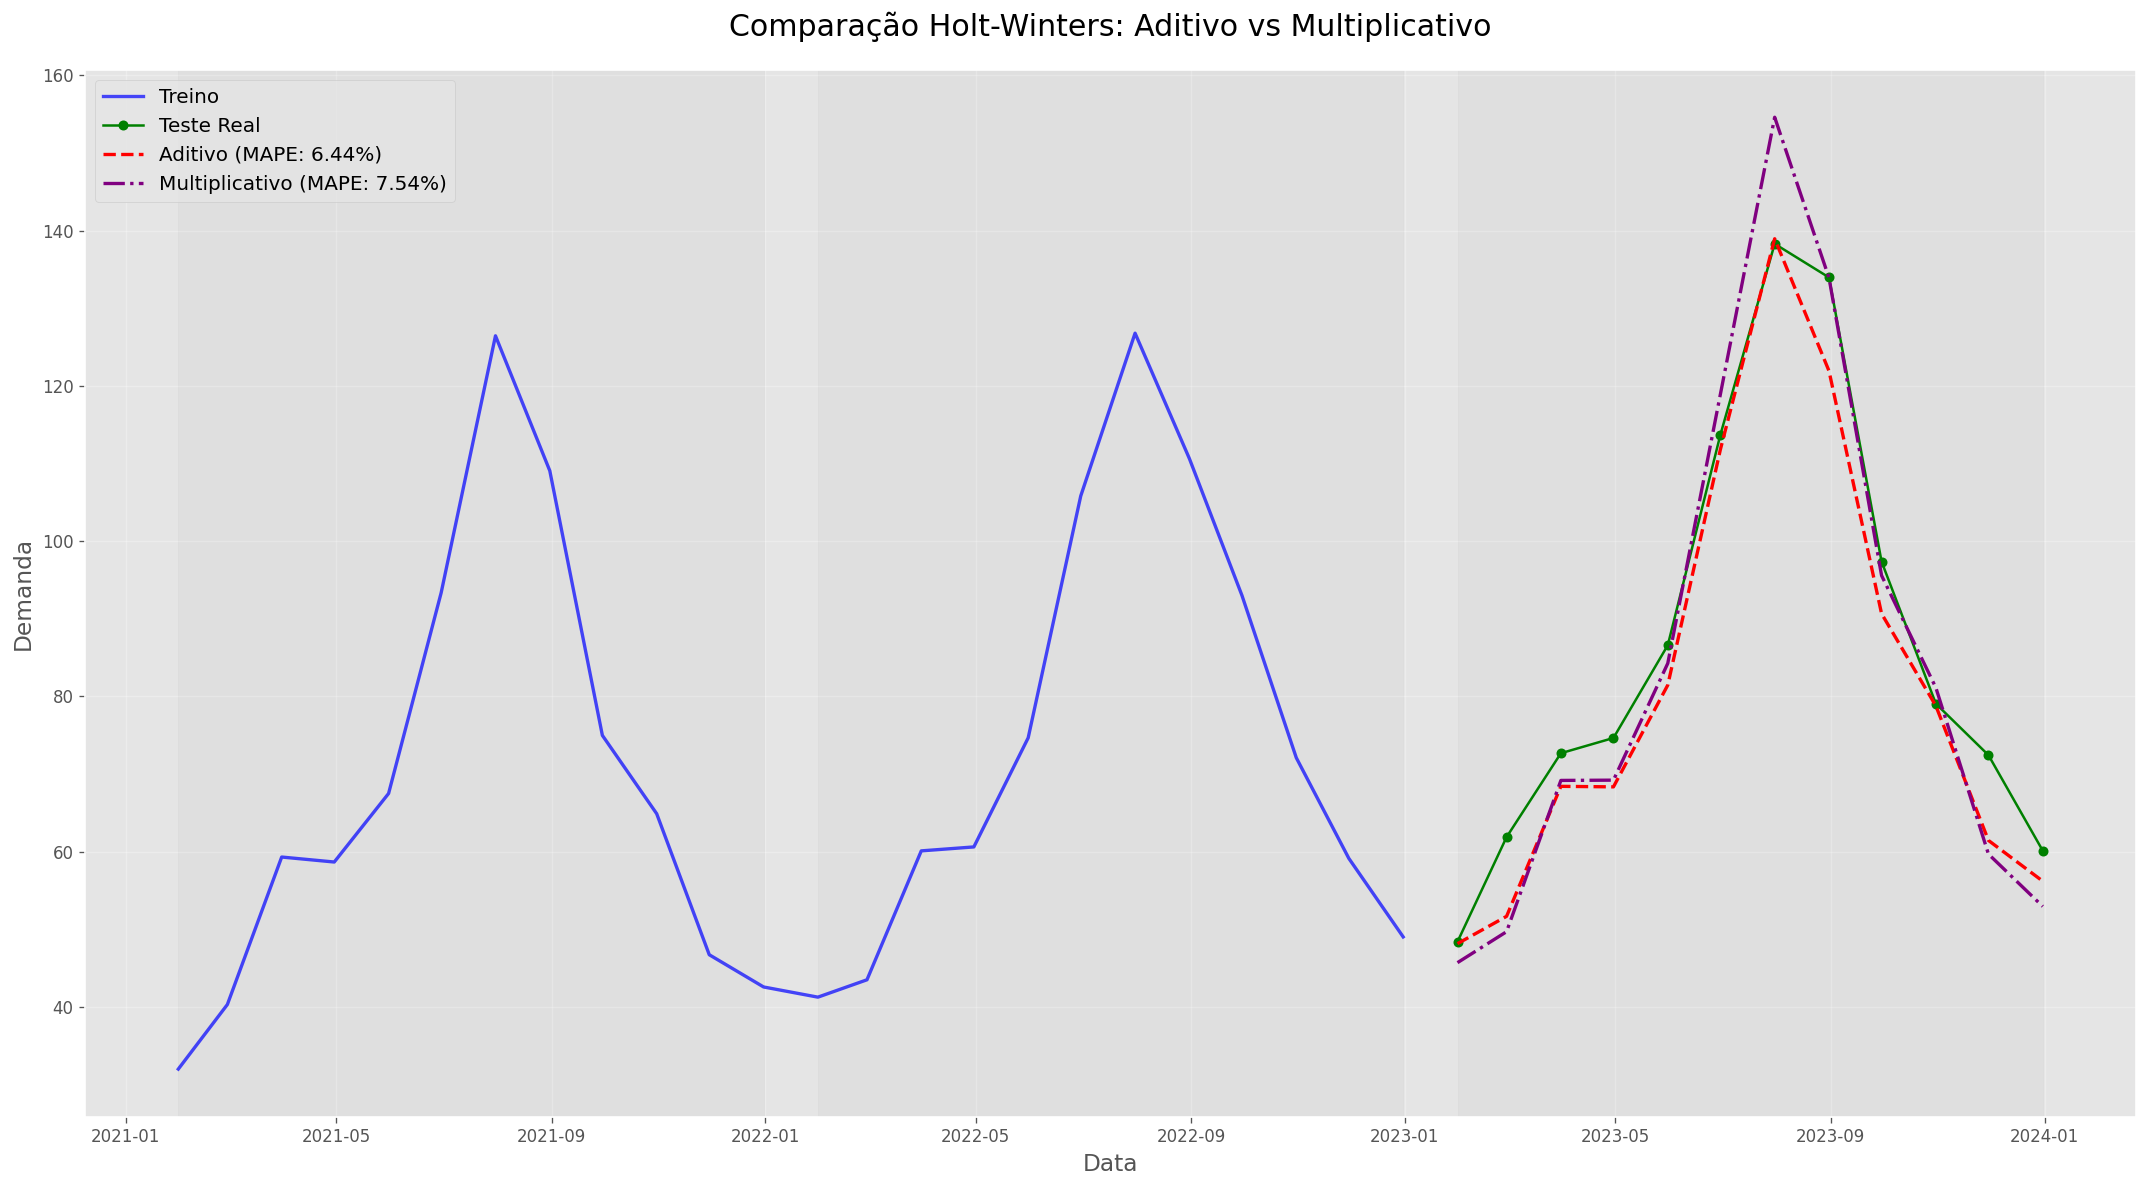


Componentes do Modelo Aditivo:


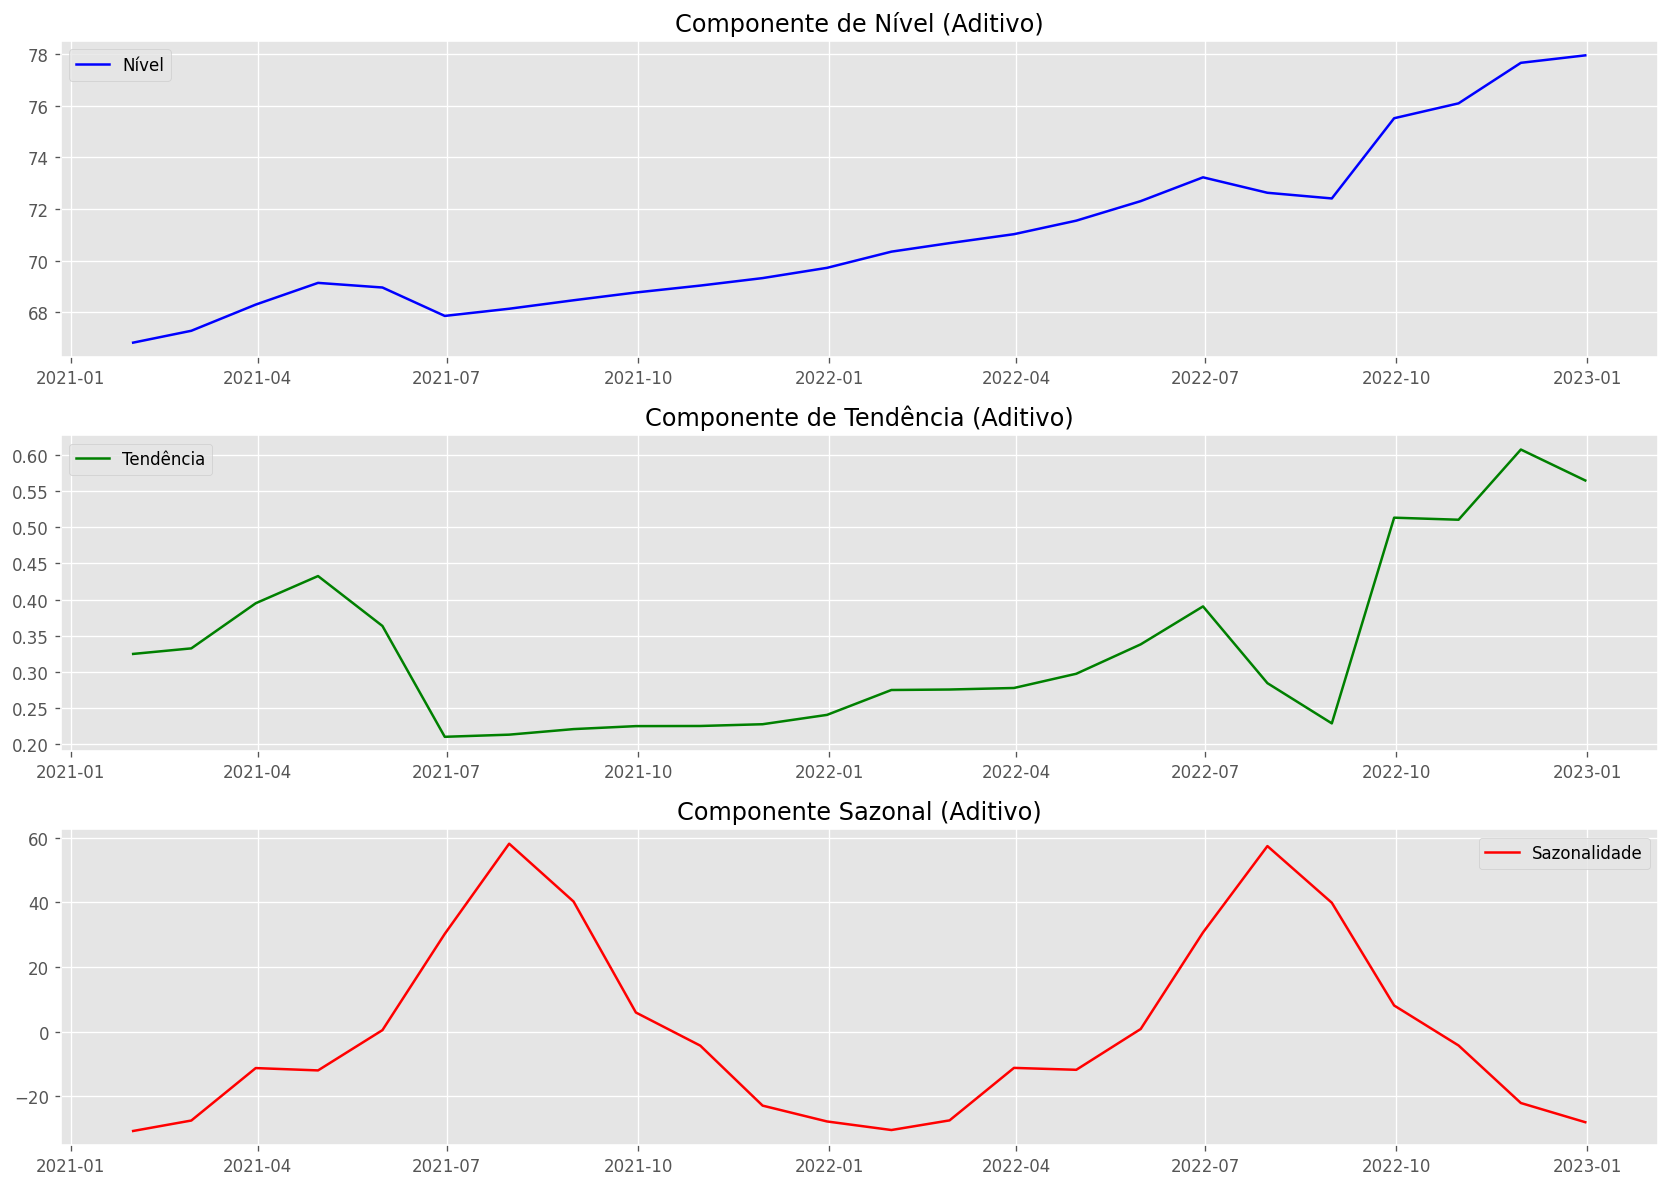


Componentes do Modelo Multiplicativo:


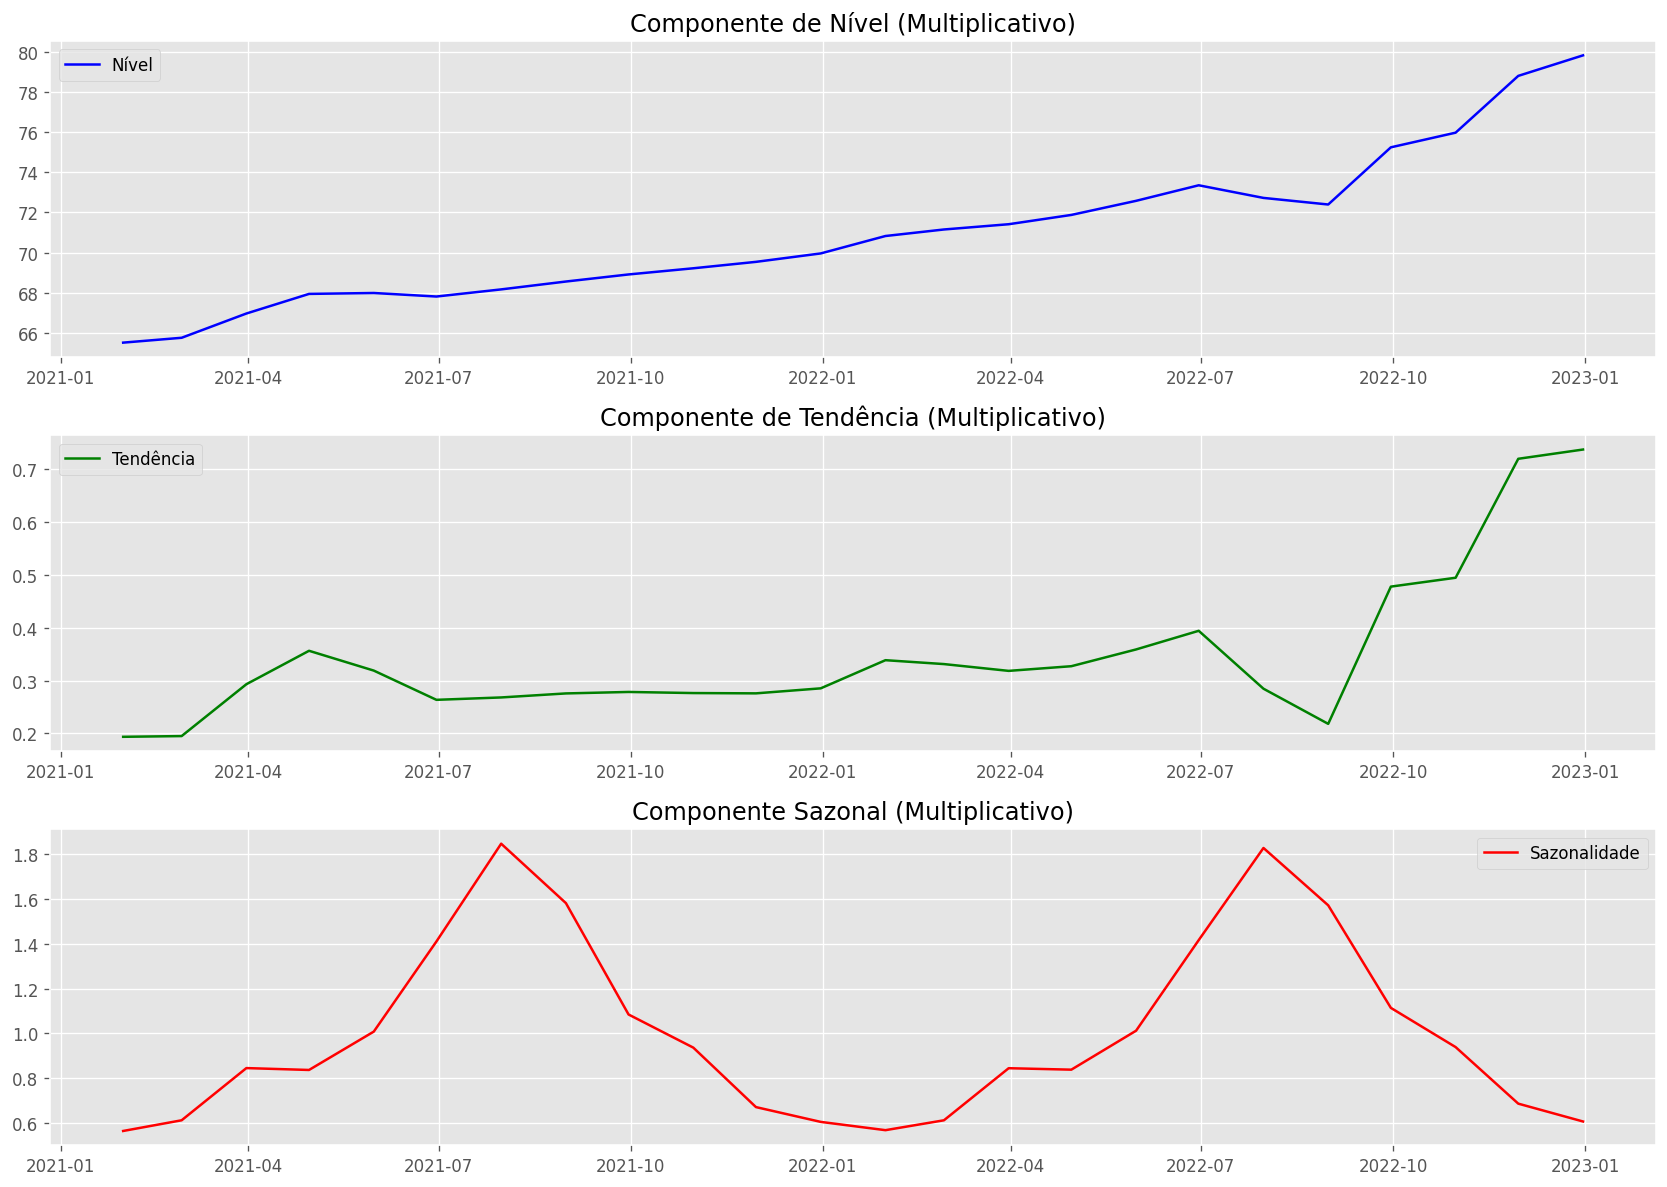


                     RESULTADOS FINAIS                      

• Melhor modelo: Aditivo (MAPE: 6.44%)
• Parâmetros utilizados:
  Alpha (α): 0.2
  Beta (β): 0.1
  Gamma (γ): 0.15
  Phi (ϕ): 0.98


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error

# Configurações de visualização
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.grid'] = True

## 1. Criação da Base de Dados Sintética (36 meses)
np.random.seed(42)

# Padrão sazonal acentuado (base mensal)
base_demand = np.array([30, 40, 55, 50, 65, 90, 115, 100, 70, 55, 40, 35])

# Tendência de crescimento
tendency = np.linspace(0, 30, 36)  # Crescimento de 30 unidades em 3 anos

# Sazonalidade (3 anos)
seasonality = np.tile(base_demand, 3)

# Ruído controlado
noise = np.random.normal(0, 4, 36)

# Demanda final
demand = seasonality + tendency + noise

# Datas mensais (3 anos)
dates = pd.date_range(start='2021-01-01', periods=36, freq='M')

# DataFrame final
df = pd.DataFrame({'Data': dates, 'Demanda': demand})
df.set_index('Data', inplace=True)

## 2. Divisão dos Dados (24 meses treino / 12 meses teste)
train = df.iloc[:24]
test = df.iloc[24:]

## 3. Definição dos Parâmetros
PARAMETROS = {
    'alpha': 0.2,    # Peso para o nível
    'beta': 0.1,     # Peso para a tendência
    'gamma': 0.15,   # Peso para sazonalidade
    'phi': 0.98      # Fator de amortecimento
}

## 4. Modelagem Comparativa
def ajustar_modelo(dados, seasonal_type, parametros):
    modelo = ExponentialSmoothing(
        dados,
        trend='add',
        seasonal=seasonal_type,
        seasonal_periods=12,
        damped_trend=True,
        initialization_method='estimated'
    )
    return modelo.fit(
        smoothing_level=parametros['alpha'],
        smoothing_trend=parametros['beta'],
        smoothing_seasonal=parametros['gamma'],
        damping_trend=parametros['phi'],
        optimized=False
    )

# Ajuste dos modelos
modelo_aditivo = ajustar_modelo(train['Demanda'], 'add', PARAMETROS)
modelo_multiplicativo = ajustar_modelo(train['Demanda'], 'mul', PARAMETROS)

# Previsões
forecast_aditivo = modelo_aditivo.forecast(len(test))
forecast_multiplicativo = modelo_multiplicativo.forecast(len(test))

# Cálculo de métricas
mape_aditivo = mean_absolute_percentage_error(test['Demanda'], forecast_aditivo) * 100
mape_multiplicativo = mean_absolute_percentage_error(test['Demanda'], forecast_multiplicativo) * 100

## 5. Visualização Comparativa
plt.figure(figsize=(18, 10))
plt.plot(train.index, train['Demanda'], label='Treino', color='blue', alpha=0.7, linewidth=2)
plt.plot(test.index, test['Demanda'], label='Teste Real', color='green', marker='o', markersize=5)
plt.plot(test.index, forecast_aditivo, label=f'Aditivo (MAPE: {mape_aditivo:.2f}%)', 
         color='red', linestyle='--', linewidth=2)
plt.plot(test.index, forecast_multiplicativo, label=f'Multiplicativo (MAPE: {mape_multiplicativo:.2f}%)', 
         color='purple', linestyle='-.', linewidth=2)

# Destaque sazonal
for i in range(0, 36, 12):
    plt.axvspan(df.index[i], df.index[i+11], alpha=0.05, color='gray')

plt.title('Comparação Holt-Winters: Aditivo vs Multiplicativo', fontsize=18, pad=20)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Demanda', fontsize=14)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Visualização Manual dos Componentes
def plot_componentes(modelo, tipo):
    # Extrai os componentes
    nivel = modelo.level
    tendencia = modelo.trend
    sazonalidade = modelo.season
    
    # Cria figura
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10))
    
    # Plot do Nível
    ax1.plot(nivel, label='Nível', color='blue')
    ax1.set_title(f'Componente de Nível ({tipo})')
    ax1.legend()
    
    # Plot da Tendência
    ax2.plot(tendencia, label='Tendência', color='green')
    ax2.set_title(f'Componente de Tendência ({tipo})')
    ax2.legend()
    
    # Plot da Sazonalidade
    ax3.plot(sazonalidade, label='Sazonalidade', color='red')
    ax3.set_title(f'Componente Sazonal ({tipo})')
    ax3.legend()
    
    plt.tight_layout()
    plt.show()

# Plot dos componentes para ambos os modelos
print("\nComponentes do Modelo Aditivo:")
plot_componentes(modelo_aditivo, 'Aditivo')

print("\nComponentes do Modelo Multiplicativo:")
plot_componentes(modelo_multiplicativo, 'Multiplicativo')

## 7. Resultados Finais
melhor_modelo = modelo_aditivo if mape_aditivo < mape_multiplicativo else modelo_multiplicativo
melhor_tipo = 'Aditivo' if mape_aditivo < mape_multiplicativo else 'Multiplicativo'

print("\n" + "="*60)
print("RESULTADOS FINAIS".center(60))
print("="*60)
print(f"\n• Melhor modelo: {melhor_tipo} (MAPE: {min(mape_aditivo, mape_multiplicativo):.2f}%)")
print(f"• Parâmetros utilizados:")
print(f"  Alpha (α): {PARAMETROS['alpha']}")
print(f"  Beta (β): {PARAMETROS['beta']}")
print(f"  Gamma (γ): {PARAMETROS['gamma']}")
print(f"  Phi (ϕ): {PARAMETROS['phi']}")